In [18]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import os
import sys
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

sys.path.append(os.path.abspath(os.path.join(os.path.pardir, 'src')))

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # or any {'0', '1', '2'}
import tensorflow as tf
import absl.logging

absl.logging.set_verbosity(absl.logging.ERROR)

# Set memory growth
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

from jem import JointEmbeddingModel, get_data

lr = 0.001
epochs = 10
batch_size = 128
num_epochs = 10
input_state_embed = 64
hidden_state_embed = 32
output_state_embed = 16 
exp_embed = 32
output_exp_embed = 16

# Load the data
states, explinations, labels, vocab_size = get_data(batch_size=batch_size)
max_sent_len = explinations.shape[1]

jem = JointEmbeddingModel(vocab_size=vocab_size, max_sent_len=max_sent_len, learning_rate=lr)

jem.fit(states, explinations, labels, batch_size=batch_size, epochs=epochs)

jem.save_model('../models/jem/joint_embedding_model.keras')

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 4, 7, 7)]    0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 4, 7, 4)      256         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 4, 7, 6)      222         ['conv2d[0][0]']                 
                                                                                                  
 flatten (Flatten)              (None, 168)          0           ['conv2d_1[0][0]']               
                                                                                              

2024-02-15 17:06:07.182826: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp_10.


1/1 [==============================] - 6s 6s/step - loss: 4.7858 - combined_output_loss: 4.7858
Epoch 2/10
1/1 [==============================] - 0s 410ms/step - loss: 3.1257 - combined_output_loss: 3.1257
Epoch 3/10
1/1 [==============================] - 0s 380ms/step - loss: 2.1540 - combined_output_loss: 2.1540
Epoch 4/10
1/1 [==============================] - 0s 410ms/step - loss: 1.6137 - combined_output_loss: 1.6137
Epoch 5/10
1/1 [==============================] - 0s 384ms/step - loss: 1.3190 - combined_output_loss: 1.3190
Epoch 6/10
1/1 [==============================] - 0s 378ms/step - loss: 1.1557 - combined_output_loss: 1.1557
Epoch 7/10
1/1 [==============================] - 0s 364ms/step - loss: 1.0651 - combined_output_loss: 1.0651
Epoch 8/10
1/1 [==============================] - 0s 362ms/step - loss: 1.0133 - combined_output_loss: 1.0133
Epoch 9/10
1/1 [==============================] - 0s 374ms/step - loss: 0.9816 - combined_output_loss: 0.9816
Epoch 10/10
1/1 [=======

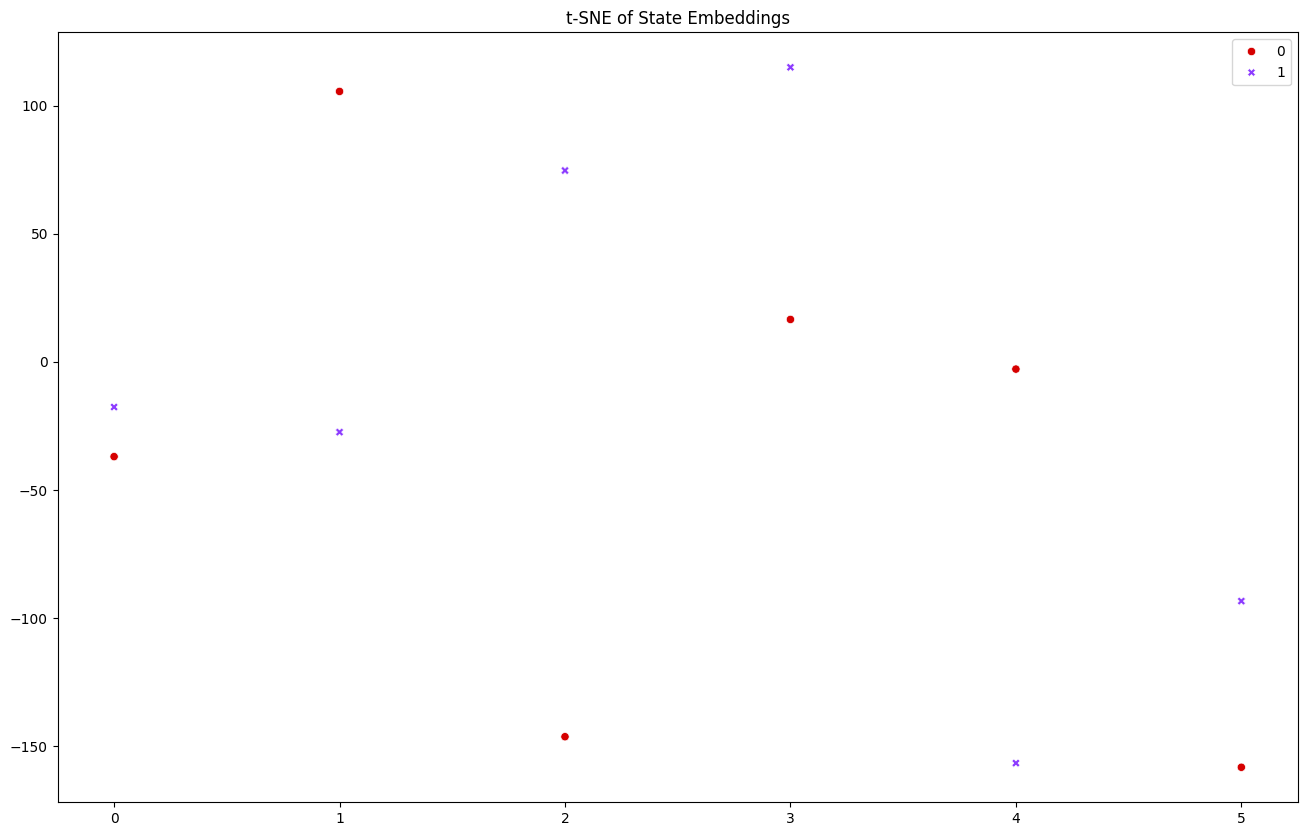

In [3]:
# Import necessary modules
from sklearn.manifold import TSNE
import seaborn as sns
import colorcet as cc

# Define necessary variables
state_embeddings = []

# Get the embeddings
for i in range(len(states)):
    state_embed, exp_embed, _ = jem.predict(states[i], explinations[i])
    state_embeddings.append(state_embed)

new_state_embed = []

for list_ in state_embeddings:
    new_state_embed.append(list_[0])
    
new_state_embed = np.array(new_state_embed)

# Fit the t-sne
tsne = TSNE(n_components=2, perplexity=5)
state_embed_tsne = tsne.fit_transform(new_state_embed)

# Plot the t-sne
palette = sns.color_palette(cc.glasbey, 2)
plt.figure(figsize=(16,10))
#sns.scatterplot(data=(state_embed_tsne[:,0], state_embed_tsne[:,1]), hue=explination_predictions, legend='full', palette=palette)
sns.scatterplot(data=(state_embed_tsne[:,0], state_embed_tsne[:,1]), legend='full', palette=palette)
plt.title('t-SNE of State Embeddings')
plt.plot()
plt.show()